In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
# subset to relevant urls
humanist_urls = ["https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/", "https://humanist.kdl.kcl.ac.uk/Archives/Current/"]
volume_dfs = []
# loop through each url
for url in humanist_urls:
    print(f"Getting volumes from {url}")
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.find_all('a')
    # loop through each volume link
    for link in links:
        if link['href'].endswith('.txt'):
            print(f"Getting volume from {url + link['href']}")
            page_soup = BeautifulSoup(requests.get(url + link['href']).text, "html.parser")
            text = page_soup.get_text()
            volume_link = url + link['href']
            dates = link['href'].split('.')[1]
            data_dict = {'volume_text': text, 'volume_link': volume_link, 'volume_dates': dates}
            volume_dfs.append(data_dict)

scraped_humanist_df = pd.DataFrame(volume_dfs)
# Extract the volume number from the dates
scraped_humanist_df['volume_number'] = scraped_humanist_df['volume_dates'].str.extract(r'(\d+)')
# Remove numbers with more than 2 digits
scraped_humanist_df['volume_number'] = scraped_humanist_df['volume_number'].apply(lambda x: np.nan if len(str(x)) > 2 else x)

# Replace nulls with a sequential of volume numbers
scraped_humanist_df['volume_number'] = scraped_humanist_df['volume_number'].fillna(pd.Series(np.arange(1, len(scraped_humanist_df) + 1)))

# Extract the start and end years
scraped_humanist_df[['inferred_start_year', 'inferred_end_year']] = scraped_humanist_df['volume_dates'].str.split('-', expand=True)

# Remove years that are not 4 digits
scraped_humanist_df.inferred_start_year = scraped_humanist_df.inferred_start_year.apply(lambda x: np.nan if len(str(x)) != 4 else x)
scraped_humanist_df.inferred_end_year = scraped_humanist_df.inferred_end_year.apply(lambda x: np.nan if len(str(x)) != 4 else x)

# Ensure the years are numeric
scraped_humanist_df.loc[scraped_humanist_df.inferred_end_year.isnull(), 'inferred_end_year'] = np.nan

# Create an empty dummy variable for the years
start_year_before = None
end_year_before = None

# Loop through dataframe row by row
for index, row in scraped_humanist_df.iterrows():
    # Check that both start and end years are not null
    if (not pd.isnull(row.inferred_start_year)) and (not pd.isnull(row.inferred_end_year)):
        # assign the years to the dummy variables
        start_year_before = row.inferred_start_year
        end_year_before = row.inferred_end_year
        # print the years
        print(start_year_before, end_year_before)
    # Check that if years are null and the dummy variables are not, then update the years in the dataframe
    elif (pd.isnull(row.inferred_start_year) and start_year_before is not None) and (pd.isnull(row.inferred_end_year) and end_year_before is not None):
        # increment the years by 1
        start_year_before = int(start_year_before) + 1
        end_year_before = int(end_year_before) + 1
        # assign the years to the dataframe using the row index to update the original dataframe
        scraped_humanist_df.at[index, 'inferred_start_year'] = start_year_before
        scraped_humanist_df.at[index, 'inferred_end_year'] = end_year_before
        print(start_year_before, end_year_before)

# Save the dataframe to a csv
scraped_humanist_df.to_csv("web_scraped_humanist_listserv_volumes.csv", index=False)

Getting volumes from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/


KeyboardInterrupt: 

In [21]:
import pandas as pd
humanist_vols = pd.read_csv('web_scraped_humanist_listserv_volumes.csv')
# Check the data types of our columns
humanist_vols.dtypes

volume_text            object
volume_link            object
volume_dates           object
volume_number           int64
inferred_start_year     int64
inferred_end_year       int64
dtype: object

In [37]:
humanist_vols = humanist_vols.dropna()

In [38]:
# Extract the volume number from the dates
humanist_vols['volume_number'] = humanist_vols['volume_dates'].str.extract(r'(\d+)')

C:\Users\malli\AppData\Local\Temp\ipykernel_4400\759725664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humanist_vols['volume_number'] = humanist_vols['volume_dates'].str.extract(r'(\d+)')


In [39]:
# Extract the start and end years
humanist_vols[['inferred_start_year', 'inferred_end_year']] = humanist_vols['volume_dates'].str.split('-', expand=True)

C:\Users\malli\AppData\Local\Temp\ipykernel_4400\3756181714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humanist_vols[['inferred_start_year', 'inferred_end_year']] = humanist_vols['volume_dates'].str.split('-', expand=True)


In [40]:
# Count the number of characters in each volume
humanist_vols['volume_size'] = humanist_vols['volume_text'].str.count('\n')

C:\Users\malli\AppData\Local\Temp\ipykernel_4400\735073610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humanist_vols['volume_size'] = humanist_vols['volume_text'].str.count('\n')


In [41]:
humanist_vols.head()

,volume_text,volume_link,volume_dates,volume_number,inferred_start_year,inferred_end_year,volume_size
0,From: MCCARTY@UTOREPAS\nSubject: \nDate: 12 Ma...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1987-1988,1987,1987,1988,50794
1,From: Sebastian Rahtz \nSubject: C++ and Gnu o...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1988-1989,1988,1988,1989,36109
2,From: Willard McCarty \nSubject: Happy Birthda...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1989-1990,1989,1989,1990,108695
3,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1990-1991,1990,1990,1991,118929
4,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1991-1992,1991,1991,1992,81193


In [43]:
import numpy as np
np.unique(humanist_vols['inferred_start_year'].values)

array(['1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007'], dtype=object)

<Axes: xlabel='inferred_start_year'>

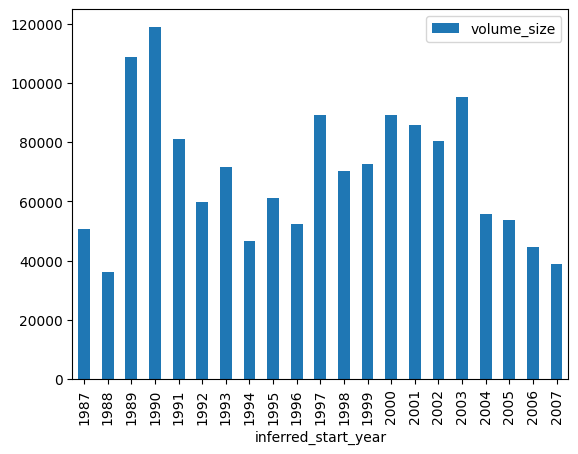

In [42]:
# Plot the data
humanist_vols.plot(x='inferred_start_year', y='volume_size', kind='bar')

In [44]:
import altair as alt
# Convert the inferred start year to a datetime object
humanist_vols['inferred_start_year'] = humanist_vols['inferred_start_year'].astype(str) + '-01-01'
humanist_vols['inferred_start_year'] = pd.to_datetime(humanist_vols['inferred_start_year'])
# Subset the data to only include the volume size and inferred start year so that our chart is not huge
chart = alt.Chart(humanist_vols[['volume_size', 'inferred_start_year']]).mark_bar().encode(
    x='inferred_start_year:T',
    y='volume_size',
    tooltip=['inferred_start_year', 'volume_size']
)

C:\Users\malli\AppData\Local\Temp\ipykernel_4400\3775203170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humanist_vols['inferred_start_year'] = humanist_vols['inferred_start_year'].astype(str) + '-01-01'
C:\Users\malli\AppData\Local\Temp\ipykernel_4400\3775203170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humanist_vols['inferred_start_year'] = pd.to_datetime(humanist_vols['inferred_start_year'])


In [45]:
# Count the number of occurrences of each word
humanist_vols['humanities_computing_counts'] = humanist_vols['text'].str.count('humanities computing')
humanist_vols['digital_humanities_counts'] = humanist_vols['text'].str.count('digital humanities')

KeyError: 'text'

In [46]:
# Plot the data
humanist_vols[['humanities_computing_counts', 'digital_humanities_counts']].plot()

KeyError: "None of [Index(['humanities_computing_counts', 'digital_humanities_counts'], dtype='object')] are in the [columns]"

Apply these basic methods of text analysis to the Humanist Listserv dataset to try and discover if there are any discourses that are distinctive of the early internet era versus the later web 2.0 era in the Humanist Listserv dataset

- Web 2.0: term first coined in 1999 by Darcy DiNucci then popularized by Tim O’Reilly in 2004
- Refers to the shift from static web pages to dynamic and user-generated content
- Early internet era is a bit more difficult to define, but we could say it starts in the 1980s and ends in the late 1990s.

1. Make sure you have the Humanist listserv dataset and that you have dates associated with each volume. Also if you previously save a subset of the dataset, try rerunning the code to use the whole dataset.

2. Highly recommend using TF-IDF to help identify what is distinctive of these two time periods. You can use the code from the tutorial above to help you get started. You may also chose to use other Python libraries or methods, though I would recommend starting with TF-IDF. Part of this assignment is thinking about what we mean by “distinctive” and “discourse”, and how we can use computational methods to help us answer these questions. You could for example experiment with lemmatization or stemming to see if that changes your results, or you could try different hyper-parameters for TF-IDF.

3. Need to visualize your results, and while you’re welcome to use any library, I would recommend either using Pandas plot or Altair. You’re welcome to work in either a Python script or Jupyter notebook, though I would recommend starting in a Jupyter notebook. Because of the size of the dataset, you may want to try and use a subset of the data to start with. You can do this with the sample method in Pandas. For example, to get a random sample of 100 rows you could use the following code: humanist_vols.sample(100)

4. You’ll also want to make sure that you aren’t trying to push up to GitHub any file larger than 50MB. To ignore those files, be sure to add them to your .gitignore file. You can read more about how to do that here https://docs.github.com/en/github/using-git/ignoring-files and in our previous lesson. And you can always ask GitHub Co-Pilot or the instructors for assistance.
